<h4>Cut List Optimizer</h4>

<h5>Import Libraries</h5>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path
import matplotlib.patches as patches


<h5>Load the glass sheet size data</h5>

In [2]:
glass_df = pd.read_csv('data/glass_data.csv')
display(glass_df)

,location,glass_length,glass_height,glass_qty,area_sqm
0,CWG-101,973,1883,6,10.993
1,CWG-202 & 302,973,1608,12,18.775
2,CWG-403,976,2358,3,6.904
3,CWG-GF04 & Mezz,952,1738,45,74.456
4,CWG-105&205,1010,1594,75,120.746
5,CWG-06,964,1603,56,86.536
6,CWG-07,964,1902,14,25.669
7,CWG-08,951,2263,7,15.065
8,CWG-09,951,2218,7,14.765
9,CWG-10,954,2268,7,15.146


In [3]:
def calculate_total_glass_area(glass_df):
    cut_glass_area_sqm = round(glass_df['area_sqm'].sum(), 3)
    total_cut_glass_qty = glass_df['glass_qty'].sum()
    return cut_glass_area_sqm, total_cut_glass_qty

cut_glass_area_sqm, total_cut_glass_qty = calculate_total_glass_area(glass_df)

print("Actual Cutting Glass Area (sqm):", cut_glass_area_sqm)
print("Total Cutting Glass Quantity:", total_cut_glass_qty)

Actual Cutting Glass Area (sqm): 451.142
Total Cutting Glass Quantity: 260


In [4]:
# Load the glass sheet size data
glass_stock_df = pd.read_csv('data/glass_sheet_size.csv')

def calculate_stock_sheet_area_row(df):
    df['sheet_area_row'] = (df['length'] / 1000) * (df['width'] / 1000) * df['qty']
    return df

glass_stock_df = calculate_stock_sheet_area_row(glass_stock_df)

display(glass_stock_df)

,particulars,length,width,qty,sheet_area_row
0,glass_stock_size,3300,2438,100,804.54
1,glass_stock_size,3300,2100,50,346.50
2,glass_stock_size,2438,2100,50,255.99


In [5]:
def calculate_total_stock_sheet_area(glass_stock_df):
    total_sheet_glass_qty = glass_stock_df['qty'].sum()
    sheet_glass_area_sqm = round(glass_stock_df['sheet_area_row'].sum(), 3)
    return total_sheet_glass_qty, sheet_glass_area_sqm

total_sheet_glass_qty, sheet_glass_area_sqm = calculate_total_stock_sheet_area(glass_stock_df)

print("Total Glass Sheet Quantity:", total_sheet_glass_qty)
print("Stock Sheet Glass Area (sqm):", sheet_glass_area_sqm)

Total Glass Sheet Quantity: 200
Stock Sheet Glass Area (sqm): 1407.03


<h3>Manual Optimization Loop</h3>
<p>This nested loop iterates over each glass piece and tries to fit it into the available stock sheets. If a suitable stock sheet is found, the glass piece is placed, and the stock sheet's quantity is updated. The remaining space on the stock sheet is calculated and recorded.</p>

In [6]:
# # Initialize the lists
# cuts = []
# used_stocks = []
# stock_usage = []
# sheet_usage = {}

# # Manual optimization
# for _, glass_row in glass_df.iterrows():
#     for _ in range(glass_row['glass_qty']):
#         for stock_idx, stock_row in glass_stock_df.iterrows():
#             if (glass_row['glass_length'] <= stock_row['length'] and 
#                 glass_row['glass_height'] <= stock_row['width'] and
#                 stock_row['qty'] > 0):
                
#                 # Calculate remaining space on the stock after placing the glass piece
#                 remaining_length = stock_row['length'] - glass_row['glass_length']
#                 remaining_width = stock_row['width'] - glass_row['glass_height']
                
#                 # Place the glass piece on the stock sheet
#                 cuts.append({
#                     'stock_idx': stock_idx,
#                     'x': stock_row['length'] - remaining_length, 
#                     'y': stock_row['width'] - remaining_width,
#                     'width': glass_row['glass_length'],
#                     'height': glass_row['glass_height']
#                 })

#                 # Update the stock sheet
#                 glass_stock_df.at[stock_idx, 'qty'] -= 1
#                 used_stocks.append(stock_idx)
#                 stock_usage.append({
#                     'stock_idx': stock_idx,
#                     'remaining_length': remaining_length,
#                     'remaining_width': remaining_width,
#                     'glass_length': glass_row['glass_length'],
#                     'glass_height': glass_row['glass_height']
#                 })
                
#                 # Update sheet usage counter
#                 sheet_size = (stock_row['length'], stock_row['width'])
#                 if sheet_size not in sheet_usage:
#                     sheet_usage[sheet_size] = 0
#                 sheet_usage[sheet_size] += 1
                
#                 break

# # Create a DataFrame from stock_usage
# stock_usage_df = pd.DataFrame(stock_usage)

# # Display the DataFrame
# display(stock_usage_df)

# # Display the remaining quantity of stock sheets
# remaining_stock_df = glass_stock_df[['length', 'width', 'qty']]
# display(remaining_stock_df)


In [7]:
# Initialize the lists
cuts = []
used_stocks = []
stock_usage = []
sheet_usage = {}

# Manual optimization
for _, glass_row in glass_df.iterrows():
    for _ in range(glass_row['glass_qty']):
        for stock_idx, stock_row in glass_stock_df.iterrows():
            if (glass_row['glass_length'] <= stock_row['length'] and 
                glass_row['glass_height'] <= stock_row['width'] and
                stock_row['qty'] > 0):
                
                # Calculate remaining space on the stock after placing the glass piece
                remaining_length = stock_row['length'] - glass_row['glass_length']
                remaining_width = stock_row['width'] - glass_row['glass_height']
                
                # Place the glass piece on the stock sheet
                cuts.append({
                    'stock_idx': stock_idx,
                    'x': stock_row['length'] - remaining_length, 
                    'y': stock_row['width'] - remaining_width,
                    'width': glass_row['glass_length'],
                    'height': glass_row['glass_height']
                })

                # Update the stock sheet
                glass_stock_df.at[stock_idx, 'qty'] -= 1
                used_stocks.append(stock_idx)
                stock_usage.append({
                    'stock_idx': stock_idx,
                    'remaining_length': remaining_length,
                    'remaining_width': remaining_width,
                    'glass_length': glass_row['glass_length'],
                    'glass_height': glass_row['glass_height']
                })
                
                # Update sheet usage counter
                sheet_size = (stock_row['length'], stock_row['width'])
                if sheet_size not in sheet_usage:
                    sheet_usage[sheet_size] = 0
                sheet_usage[sheet_size] += 1
                
                break

# Create a summary of used stocks
used_stocks_summary = pd.DataFrame(stock_usage)
used_stocks_summary['used_area'] = (used_stocks_summary['glass_length'] / 1000) * (used_stocks_summary['glass_height'] / 1000)
used_stocks_summary = used_stocks_summary.groupby(['stock_idx']).agg({'used_area': 'sum'}).reset_index()

# Merge with glass_stock_df to get size and area
used_stocks_summary = used_stocks_summary.merge(glass_stock_df[['length', 'width']], left_on='stock_idx', right_index=True)

# Calculate wastage percentage
total_sheet_area = glass_stock_df['sheet_area_row'].sum()
used_area = used_stocks_summary['used_area'].sum()
used_area_percentage = (used_area / total_sheet_area) * 100
wastage_percentage = 100 - used_area_percentage

print("Used Area Percentage:", used_area_percentage)
print("Wastage Percentage:", wastage_percentage)

# Display the summary of used stocks
print("Summary of Used Stocks:")
display(used_stocks_summary)

# Display the remaining quantity of stock sheets
remaining_stock_df = glass_stock_df[['length', 'width', 'qty']]
print("Remaining Stock Sheets:")
display(remaining_stock_df)


Used Area Percentage: 23.020869633199005
Wastage Percentage: 76.979130366801
Summary of Used Stocks:


,stock_idx,used_area,length,width
0,0,165.866066,3300,2438
1,1,79.915168,3300,2100
2,2,78.129308,2438,2100


Remaining Stock Sheets:


,length,width,qty
0,3300,2438,0
1,3300,2100,0
2,2438,2100,0


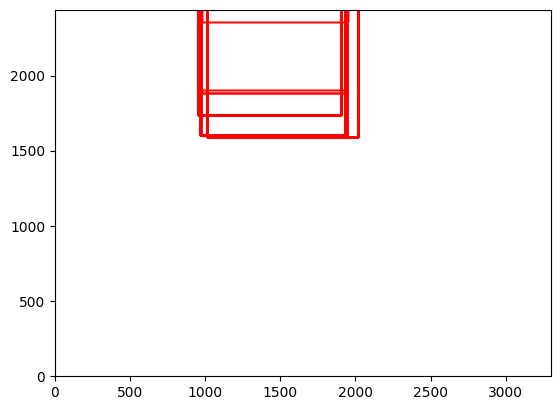

In [8]:
# Plot the cutting layout
fig, ax = plt.subplots()
for cut in cuts:
    rect = Rectangle((cut['x'], cut['y']), cut['width'], cut['height'], edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_xlim(0, glass_stock_df['length'].max())
ax.set_ylim(0, glass_stock_df['width'].max())
ax.set_aspect('equal', adjustable='box')
plt.show()

<h2>Visualization function</h2>

In [9]:
def visualize_cuts(stock_idx, stock_row, cuts, output_pdf_path):
    fig, ax = plt.subplots(figsize=(11, 8.5))  # Use letter size paper dimensions
    
    # Draw the stock sheet
    ax.add_patch(Rectangle((0, 0), stock_row['length'], stock_row['width'], 
                           edgecolor='black', facecolor='none', linewidth=2))
    
    # Draw cuts
    for cut in cuts:
        if cut['stock_idx'] == stock_idx:
            ax.add_patch(Rectangle((cut['x'], cut['y']), cut['width'], cut['height'],
                                   edgecolor='blue', facecolor='none', linewidth=1))
            
            # Add dimensions
            ax.text(cut['x'] + cut['width']/2, cut['y'] + cut['height']/2,
                    f"{int(cut['width'])}x{int(cut['height'])}", 
                    ha='center', va='center', fontsize=8, fontweight='bold')
            
            # Add dimension lines
            width_line = Path([
                (cut['x'], cut['y'] - 20), 
                (cut['x'], cut['y'] - 10), 
                (cut['x'] + cut['width'], cut['y'] - 10), 
                (cut['x'] + cut['width'], cut['y'] - 20)
            ])
            height_line = Path([
                (cut['x'] - 20, cut['y']), 
                (cut['x'] - 10, cut['y']), 
                (cut['x'] - 10, cut['y'] + cut['height']), 
                (cut['x'] - 20, cut['y'] + cut['height'])
            ])
            ax.add_patch(PathPatch(width_line, facecolor='none', edgecolor='red'))
            ax.add_patch(PathPatch(height_line, facecolor='none', edgecolor='red'))
    
    # Set limits and aspect
    ax.set_xlim(-50, stock_row['length'] + 50)
    ax.set_ylim(-50, stock_row['width'] + 50)
    ax.set_aspect('equal', adjustable='box')
    
    # Remove axes
    ax.axis('off')
    
    # Add title
    plt.title(f"Stock {stock_idx + 1}: {int(stock_row['length'])}x{int(stock_row['width'])} mm", fontsize=14, fontweight='bold')
    
    # Add stock sheet dimensions
    plt.text(stock_row['length']/2, -30, f"{int(stock_row['length'])} mm", ha='center', va='center', fontsize=10)
    plt.text(-30, stock_row['width']/2, f"{int(stock_row['width'])} mm", ha='center', va='center', rotation=90, fontsize=10)
    
    # Invert y-axis
    ax.invert_yaxis()
    
    # Adjust layout and save
    plt.tight_layout()
    
    return fig

print("Visualization function defined.")

Visualization function defined.


<h2>Generate PDF</h2>

In [10]:
# File location for saving the PDF
output_pdf_path = 'data/glass_cut_list_manual.pdf'

with PdfPages(output_pdf_path) as pdf:
    for stock_idx in set(used_stocks):
        stock_row = glass_stock_df.loc[stock_idx]
        fig = visualize_cuts(stock_idx, stock_row, cuts, output_pdf_path)
        pdf.savefig(fig)
        plt.close(fig)
    
    # Add summary page
    def add_summary_page(pdf, sheet_usage, glass_stock_df):
        fig, ax = plt.subplots(figsize=(11, 8.5))
        ax.axis('off')
        
        # Title
        ax.text(0.5, 0.95, "Sheet Usage Summary", ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Create a table of sheet usage
        data = []
        for (length, width), used_count in sheet_usage.items():
            if used_count > 0:
                total_count = glass_stock_df[(glass_stock_df['length'] == length) & (glass_stock_df['width'] == width)]['qty'].values[0]
                data.append([f"{length}x{width} mm", used_count, total_count - used_count])
        
        data.sort(key=lambda x: x[1], reverse=True)  # Sort by used count, descending
        
        table = ax.table(cellText=data, 
                         colLabels=["Sheet Size", "Quantity Used", "Quantity Remaining"],
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        for (row, col), cell in table.get_celld().items():
            if row == 0:
                cell.set_text_props(fontweight='bold')
        
        # Add total sheets used
        total_sheets_used = sum(count for count in sheet_usage.values())
        total_sheets_available = glass_stock_df['qty'].sum()
        ax.text(0.5, 0.1, f"Total Sheets Used: {total_sheets_used} out of {total_sheets_available}", 
                ha='center', va='center', fontsize=12, fontweight='bold')
        
        return fig

    # Call the summary page function
    summary_fig = add_summary_page(pdf, sheet_usage, glass_stock_df)
    pdf.savefig(summary_fig)
    plt.close(summary_fig)

print(f"PDF saved to: {output_pdf_path}")

PDF saved to: data/glass_cut_list_manual.pdf
